# Neural Style Tranferning 

In [ ]:
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import models
from torchvision import transforms
from torchvision.models import VGG19_Weights

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings("ignore")


##  Image Resizing

In [ ]:
''' 
About Mean and Std ->
When the VGG19 model was originally trained on ImageNet, all training images were:

Resized to >> 224×224
Converted from [0, 255] → [0, 1] (by dividing by 255)
Normalized using these exact mean and std values
So to get optimal performance from the pre-trained model, your input images must undergo the same preprocessing.

This is called data distribution alignment.'''
class imageResizer:
    def __init__(self, target_size):
        self.target_size = target_size
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

    def _resize_preserve_aspect(self, img: Image.Image) -> Image.Image:
        width, height = img.size
        if min(width, height) == self.target_size:
            return img

        scale = self.target_size / min(width, height)
        new_width = int(width * scale)
        new_height = int(height * scale)

        new_width = (new_width // 32) * 32
        new_height = (new_height // 32) * 32

        if min(new_width, new_height) < self.target_size:
            if new_width < new_height:
                new_width += 32
            else:
                new_height += 32

        return img.resize((new_width, new_height), Image.LANCZOS) # resize the image to new shape using the LANCZOS method

    def _validate_vgg19_compatibility(self, size: Tuple[int, int]):
        """Ensure spatial dimensions(feature maps ) are multiples of 32 (VGG19 stride)"""
        width, height = size
        if width % 32 != 0 or height % 32 != 0:
            print(f"Warning: Spatial dimensions ({width}x{height}) not divisible by 32.")

    def deprocess_image(self, tensor: torch.Tensor, original_size: Tuple[int, int]) -> Image.Image:
        """Convert processed tensor back to display PIL Image"""
        # Removing batch dimension if present
        if tensor.dim() == 4:
            tensor = tensor.squeeze(0)
            
        # Clip to valid range and convert to PIL image
        img = torch.clamp(tensor, 0, 1)
        img = transforms.ToPILImage()(img)

        if img.size != original_size:
            img = img.resize(original_size, Image.LANCZOS) ## uggrading the pixels

        return img

    def load_image(self, image_path: str) -> Tuple[torch.Tensor, Tuple[int, int]]:
        """
        Load image, resize to match spatial dimensions, and preprocess for VGG19
        
        Returns:
            preprocessed: Tensor of shape (1, 3, H, W) ready for model
            original_size: Original (width, height) for deprocessing
        """
        img = Image.open(image_path).convert('RGB')
        original_size = img.size

        if self.target_size:
            img = self._resize_preserve_aspect(img)

        self._validate_vgg19_compatibility(img.size)

        img_tensor = transforms.ToTensor()(img).unsqueeze(0)  # [0,1] range
        return img_tensor, original_size

### Redesigning the Pretrained model -VGG19

In [ ]:
class VGGFeatureExtractor(nn.Module):
    def __init__(self, content_layers: List[str], style_layers: List[str]):
        super().__init__()
        self.content_layers = set(content_layers)
        self.style_layers = set(style_layers)

        vgg_features = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features
        vgg_features.eval()
        for param in vgg_features.parameters():
            param.requires_grad = False

        self.features = self._build_model(vgg_features)

    def _build_model(self, vgg_features: nn.Sequential) -> nn.Sequential:
        """
        Builds a new sequential model from VGG features, naming layers
        and replacing MaxPool with AvgPool for better style transfer .
        """
        model = nn.Sequential()
        i, j = 1, 1 # i for conv block, j for conv layer within the block

        for layer in vgg_features:
            if isinstance(layer, nn.Conv2d):
                name = f"conv{i}_{j}"
            elif isinstance(layer, nn.ReLU):
                name = f"relu{i}_{j}"
                layer = nn.ReLU(inplace=False)
                j += 1
            elif isinstance(layer, nn.MaxPool2d):
                name = f"pool_{i}"
                # Use AvgPool for better gradient flow
                layer = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
                i += 1
                j = 1 # Reset conv layer counter after a pooling layer
            else:
                name = f"unknown_{i}_{j}"

            model.add_module(name, layer)

        return model

    def forward(self, x: torch.Tensor):
        """Extracts features from content and style layers seperately"""
        content_features = {}
        style_features = {}

        for name, layer in self.features.named_children():
            x = layer(x)
            if name in self.content_layers:
                content_features[name] = x
            if name in self.style_layers:
                style_features[name] = x

        return {'content': content_features, 'style': style_features}

## Gram Matrix

The **Gram matrix** is the correlation among all feature maps.  
Think of feature maps as detectors for different image patterns, such as shapes on a face (eyes, nose, mouth, etc.).  
The Gram matrix calculates how these features relate to each other — for example:  
- how the mouth comes below the nose,  
- how eyes are positioned on each side of the face,  
- and their overall alignment.

---

### Example: Calculating the Gram Matrix from a Feature Map

Suppose we have a tensor of shape **(1, 3, 4, 4)**:  
- `3` → number of feature maps  
- each feature map → size **4×4**

We reshape this tensor to **(3, 16)**.  
Now, we have a matrix with 3 rows and 16 columns:

- **Row 1:** The unrolled 4×4 feature map from the **"Red Detector"** filter.  
- **Row 2:** The unrolled 4×4 feature map from the **"Vertical Line"** filter.  
- **Row 3:** The unrolled 4×4 feature map from the **"Horizontal Line"** filter.  

---

### Why Do This?

This step **discards spatial information**.  
We no longer know the exact position in the 4×4 grid where a feature appeared.  
Instead, we only know its **overall response across all 16 positions**.  

👉 This is exactly what we want for **style representation**.

## Style Transfering

In [ ]:
class styleTransfering:
    def __init__(self, content_layers, style_layers):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.content_layers = content_layers or ['relu4_2']
        self.style_layers = style_layers or ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']

        self.feature_extractor = VGGFeatureExtractor(self.content_layers, self.style_layers).to(self.device)

        self.content_weight = 1
        self.style_weight = 1e6  # # this is set to high , it will be used for the total loss calculation,model aggeressively tries to apply the style on the content
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def set_targets(self, content_image, style_image):
        '''Here , we will be setting our goal for the final result img, the style -> gram matrix and content object'''
        content_image = content_image.to(self.device)
        style_image = style_image.to(self.device)

        with torch.no_grad():
            norm_content = self.normalize(content_image)
            norm_style = self.normalize(style_image)
            # we are passingg the content image to the VGG to extract the content feature
            self.content_target = self.feature_extractor(norm_content)['content'] 
            # passing the style image to the same vgg to extract the style feature and build the gram matrix
            style_features = self.feature_extractor(norm_style)['style']
            self.style_target = {name: self._gram_matrix(feat) for name, feat in style_features.items()}

    def _gram_matrix(self, style: torch.Tensor):
        _, c, h, w = style.size()
        features = style.view(c, h * w)
        gram = torch.mm(features, features.t()) / (c * h * w)
        return gram

    def loss_calculation(self, generated_feature):
        content_loss = 0
        for name, feat in generated_feature['content'].items():
            content_loss += torch.mean((feat - self.content_target[name]) ** 2)
        content_loss /= len(self.content_layers) if self.content_layers else 1

        style_loss = 0
        for name, feat in generated_feature['style'].items():
            gram = self._gram_matrix(feat)
            style_loss += torch.mean((gram - self.style_target[name]) ** 2)
        style_loss /= len(self.style_layers) if self.style_layers else 1

        return content_loss, style_loss

    def transfer_style(self, content_path, style_path, iteration=300, target_size=512, log_interval=50):
        resizer = imageResizer(target_size=target_size)

        content_tensor, content_size = resizer.load_image(content_path)
        style_img = Image.open(style_path).resize((content_tensor.shape[3], content_tensor.shape[2]), Image.LANCZOS)
        style_tensor = transforms.ToTensor()(style_img).unsqueeze(0)

        self.set_targets(content_tensor, style_tensor)

        # Use random noise of same shape of content image 
        generated_image = torch.rand_like(content_tensor).to(self.device).requires_grad_(True)

        optimizer = optim.LBFGS([generated_image], lr=1)# using the LBFGS >> due to its second order optimization which can converge quikly to lower losses,
                                                        # rather than Adam >> would do the over smoothning in the quality 

        print(f"Generating styled image for {iteration} iterations...")

        for run in range(1, iteration + 1):
            def closure():
                generated_image.data.clamp_(0, 1)
                optimizer.zero_grad()
                norm_generated = self.normalize(generated_image)
                generated_features = self.feature_extractor(norm_generated)
                content_loss, style_loss = self.loss_calculation(generated_features)
                total_loss = self.content_weight * content_loss + self.style_weight * style_loss
                total_loss.backward()
                return total_loss

            optimizer.step(closure)

            if run % log_interval == 0:
                with torch.no_grad():
                    norm_generated = self.normalize(generated_image)
                    generated_features = self.feature_extractor(norm_generated)
                    content_loss, style_loss = self.loss_calculation(generated_features)
                    total_loss = self.content_weight * content_loss + self.style_weight * style_loss
                    print(f"Iteration {run}/{iteration}, Content Loss: {content_loss.item():.4f}, Style Loss: {style_loss.item():.4f}, Total Loss: {total_loss.item():.4f}")

        print("Optimization complete.")
        return resizer.deprocess_image(generated_image.detach(), content_size)


## Building the Final Image

Using device: cuda
Generating styled image for 600 iterations...
Iteration 50/600, Content Loss: 0.0448, Style Loss: 0.0000, Total Loss: 0.1050
Iteration 100/600, Content Loss: 0.0571, Style Loss: 0.0000, Total Loss: 0.1468
Iteration 150/600, Content Loss: 0.0868, Style Loss: 0.0000, Total Loss: 0.2093
Iteration 200/600, Content Loss: 24.3608, Style Loss: 0.2093, Total Loss: 209275.3125
Iteration 250/600, Content Loss: 0.0488, Style Loss: 0.0000, Total Loss: 0.1097
Iteration 300/600, Content Loss: 0.0508, Style Loss: 0.0000, Total Loss: 0.1152
Iteration 350/600, Content Loss: 0.0464, Style Loss: 0.0000, Total Loss: 0.1080
Iteration 400/600, Content Loss: 0.0491, Style Loss: 0.0000, Total Loss: 0.1147
Iteration 450/600, Content Loss: 0.0443, Style Loss: 0.0000, Total Loss: 0.1079
Iteration 500/600, Content Loss: 0.2686, Style Loss: 0.0000, Total Loss: 0.8729
Iteration 550/600, Content Loss: 0.0642, Style Loss: 0.0000, Total Loss: 0.1535
Iteration 600/600, Content Loss: 0.0512, Style Los

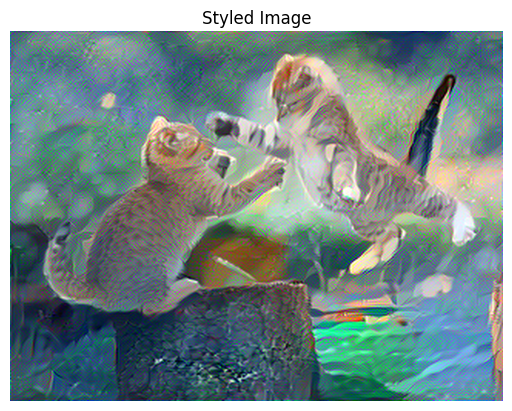

In [ ]:

if __name__ == "__main__":
    try:
        with open("content.jpg") as f: pass
        with open("style.jpg") as f: pass
    except FileNotFoundError:
        print("Creating dummy images...")
        dummy_content = Image.new('RGB', (512, 512), color='red')
        dummy_style = Image.new('RGB', (512, 512), color='blue')
        dummy_content.save("content.jpg")
        dummy_style.save("style.jpg")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    st_model = styleTransfering(
        content_layers=['relu4_2'],
        style_layers=['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
    )

    result = st_model.transfer_style(
        content_path="content.jpg",
        style_path="style.jpg",
        iteration=600,
        target_size=256
    )

    result.save('styled_image_high_quality.jpg', 'JPEG', quality=95)
    plt.imshow(result)
    plt.axis('off')
    plt.title("Styled Image")
    plt.show()
